In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import torch
import os
import shutil

#### Твой CSV

In [26]:
df = pd.read_csv("./new_code_style.csv", error_bad_lines=False)
df.head(3)

,Unnamed: 0,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,code
0,0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,1
1,1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,19
2,2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,3


#### Сами изображения

In [58]:
images = np.load("./my_data.npy", allow_pickle=True , fix_imports = True)
images.shape

(43747, 2)

#### Модель нейронной сети

In [28]:
class LeNet5(torch.nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2)
        self.act1   = torch.nn.Tanh()
        self.pool1 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        
        self.conv2 = torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, padding=0) # сделает 10,10
        self.act2  = torch.nn.Tanh()
        self.pool2 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        
        self.fc1   = torch.nn.Linear(5 * 5 * 16, 120)
        self.act3  = torch.nn.Tanh()
        
        self.fc2   = torch.nn.Linear(120, 84)
        self.act4  = torch.nn.Tanh()
        
        self.fc3   = torch.nn.Linear(84, 142)
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        
        x = self.fc1(x)
        x = self.act3(x)
        
        x = self.fc2(x)
        x = self.act4(x)
        
        x = self.fc3(x)
        
        return x

In [29]:
model = LeNet5()

In [30]:
print(model)

LeNet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (act1): Tanh()
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (act2): Tanh()
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (act3): Tanh()
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (act4): Tanh()
  (fc3): Linear(in_features=84, out_features=142, bias=True)
)


In [31]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [32]:
checkpoint = torch.load("./LeNet5.pth")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss  = checkpoint['loss']

In [64]:
list_name = df.articleType.value_counts().index
article_type_dict = {}
for i in range(len(list_name)):
    article_type_dict[list_name[i]] = i

In [73]:
article_type_dict_T = {}
for key, value in article_type_dict.items():
    article_type_dict_T[value] = key

#### Теперь делаем предикт модели

In [59]:
X = torch.FloatTensor([images[:, 0]])
y = torch.FloatTensor([images[:, 1]])

In [60]:
y = y.type(torch.LongTensor)

In [61]:
X = X.view(X.size(1) , 1, 28, 28)
y = y.view(-1)

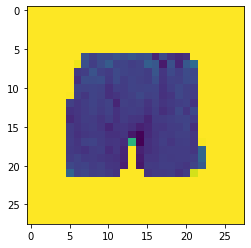

20 Shorts


In [74]:
plt.imshow(images[4][0])
plt.show()

print(images[4][1], article_type_dict_T[images[4][1]])

In [77]:
x = X[4]
x = x.unsqueeze_(0)
x.shape

torch.Size([1, 1, 28, 28])

In [81]:
predict = model.forward(x).argmax(dim=1).numpy()
predict[0]

20

Как видем номер predict и images[4][1] совподают 

In [98]:
DATASET_PATH = "D:/Data/Fashion/5000/"

In [143]:
import sys
def convert_image_to_gray_and_resize(img_path):
    # convert to gray
    try:
        src = cv2.imread(img_path, 0)

        # dsize
        dsize = (28, 28)

        # resize image
        output = cv2.resize(src, dsize)

        return output
    except:
        return []

In [144]:
predict_code = []

In [150]:
predict_list = [] 
for index, value in enumerate(df['id']):
    img = convert_image_to_gray_and_resize(DATASET_PATH + str(value) + '.jpg')
    len_img = len(img)
    if len_img == 28:
        X = torch.FloatTensor([img])
        y = torch.FloatTensor([df['code'][index]])
        y = y.type(torch.LongTensor)
        X = X.unsqueeze_(0)

        predict = model.forward(X).argmax(dim=1).numpy()
        predict_list.append(predict)
    else:
        predict_list.append(-1)

In [164]:
predict_list_2 = []

for i in predict_list:
    if 'ndarray' in str(type(i)):
        predict_list_2.append(i[0])
    else:
        predict_list_2.append(i)

In [170]:
df['predict'] = predict_list_2

In [172]:
df = df[df['predict'] != -1]

In [174]:
df.to_csv('end_style.csv')

In [175]:
df

,Unnamed: 0,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,code,predict
0,0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,1,1
1,1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,19,19
2,2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,3,3
3,3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,30,28
4,4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
44419,44419,17036,Men,Footwear,Shoes,Casual Shoes,White,Summer,2013.0,Casual,Gas Men Caddy Casual Shoe,2,2
44420,44420,6461,Men,Footwear,Flip Flops,Flip Flops,Red,Summer,2011.0,Casual,Lotto Men's Soccer Track Flip Flop,11,11
44421,44421,18842,Men,Apparel,Topwear,Tshirts,Blue,Fall,2011.0,Casual,Puma Men Graphic Stellar Blue Tshirt,0,0
44422,44422,46694,Women,Personal Care,Fragrance,Perfume and Body Mist,Blue,Spring,2017.0,Casual,Rasasi Women Blue Lady Perfume,18,3


In [ ]:
counter = 0
for i in range(len(df)):
    print(df.iloc[i])

Unnamed: 0                                           0
id                                               15970
gender                                             Men
masterCategory                                 Apparel
subCategory                                    Topwear
articleType                                     Shirts
baseColour                                   Navy Blue
season                                            Fall
year                                              2011
usage                                           Casual
productDisplayName    Turtle Check Men Navy Blue Shirt
code                                                 1
predict                                              1
Name: 0, dtype: object
Unnamed: 0                                             1
id                                                 39386
gender                                               Men
masterCategory                                   Apparel
subCategory                       

Name: 209, dtype: object
Unnamed: 0                                             210
id                                                   42614
gender                                               Women
masterCategory                                 Accessories
subCategory                                      Jewellery
articleType                                  Jewellery Set
baseColour                                            Gold
season                                              Winter
year                                                  2016
usage                                               Casual
productDisplayName    Estelle Women Earrings & Pendant Set
code                                                    66
predict                                                 65
Name: 210, dtype: object
Unnamed: 0                                           211
id                                                 12164
gender                                             Women
masterCatego

Name: 441, dtype: object
Unnamed: 0                                           442
id                                                 21528
gender                                             Women
masterCategory                               Accessories
subCategory                                         Bags
articleType                                     Handbags
baseColour                                        Copper
season                                            Winter
year                                                2015
usage                                             Casual
productDisplayName    Kiara Women Sequins Copper Handbag
code                                                   7
predict                                                7
Name: 442, dtype: object
Unnamed: 0                                      443
id                                            59432
gender                                        Women
masterCategory                          Accessories
s

Name: 655, dtype: object
Unnamed: 0                                                     656
id                                                           17849
gender                                                       Women
masterCategory                                             Apparel
subCategory                                                Topwear
articleType                                                Tshirts
baseColour                                                    Grey
season                                                        Fall
year                                                          2011
usage                                                       Casual
productDisplayName    Flying Machine Women This & That Grey Tshirt
code                                                             0
predict                                                         24
Name: 656, dtype: object
Unnamed: 0                                                   657
id            

Name: 867, dtype: object
Unnamed: 0                                                   868
id                                                         58945
gender                                                     Women
masterCategory                                     Personal Care
subCategory                                            Fragrance
articleType                                Perfume and Body Mist
baseColour                                                 White
season                                                    Spring
year                                                        2017
usage                                                     Casual
productDisplayName    Taylor of London Women White Satin Perfume
code                                                          18
predict                                                       18
Name: 868, dtype: object
Unnamed: 0                                         869
id                                               3

Name: 1078, dtype: object
Unnamed: 0                                                        1080
id                                                               14894
gender                                                           Women
masterCategory                                             Accessories
subCategory                                                Accessories
articleType                                           Travel Accessory
baseColour                                                       Black
season                                                          Summer
year                                                              2011
usage                                                           Casual
productDisplayName    United Colors of Benetton Women Solid Black Bags
code                                                                95
predict                                                             92
Name: 1080, dtype: object
Unnamed: 0               